GDL – POB_TOT: R²=0.082, MSE=8253171400
GDL – HOMBRES_18+: R²=0.992, MSE=62129893
GDL – MUJERES_18+: R²=0.358, MSE=6882506557
Jalisco – POB_TOT: R²=0.972, MSE=23546174341
Jalisco – HOMBRES_18+: R²=0.923, MSE=41147431647
Jalisco – MUJERES_18+: R²=0.945, MSE=2439503418
ZMG – POB_TOT: R²=0.927, MSE=12124386468
ZMG – HOMBRES_18+: R²=0.002, MSE=22368476500
ZMG – MUJERES_18+: R²=0.990, MSE=1556184696

📊 Clasificación: ¿Mayoría masculina (1) o femenina (0)?

Matriz de confusión:
 [[6 0]
 [0 7]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13

Precisión del modelo: 1.00

📈 Gráficas descriptivas...



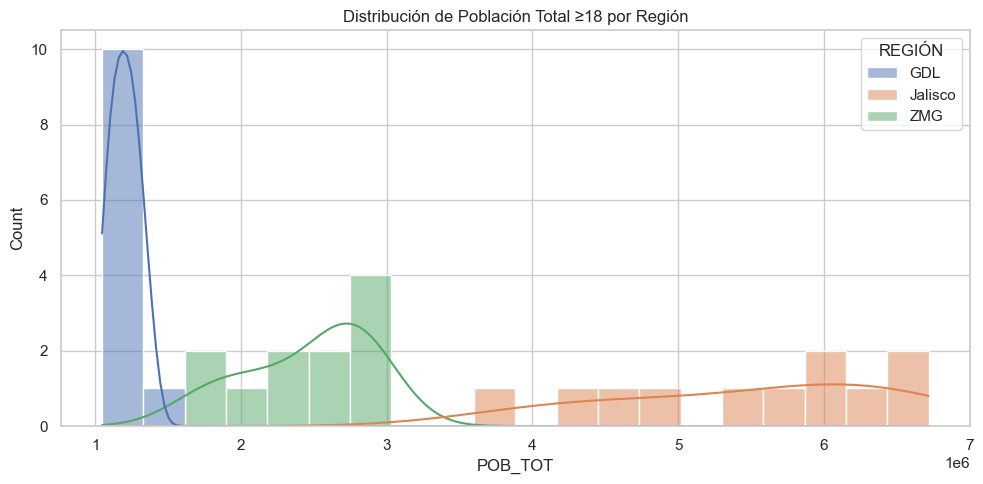

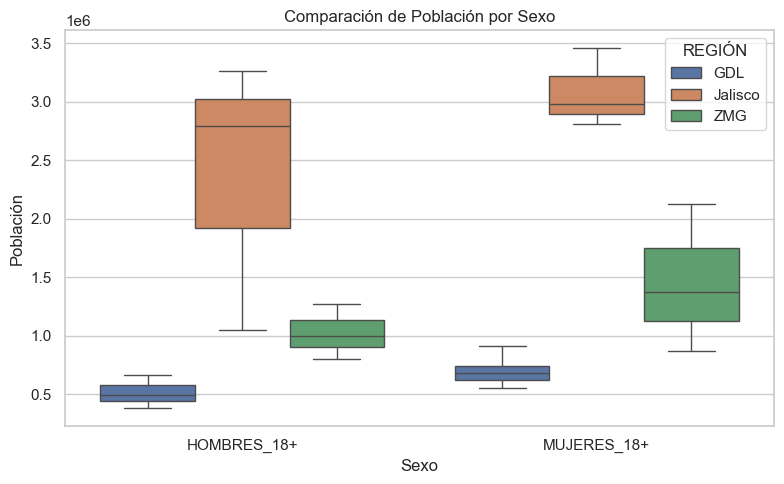

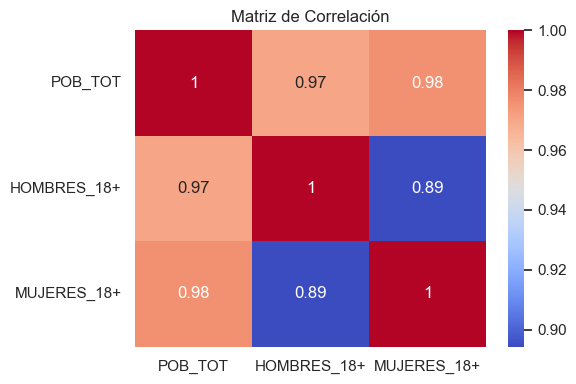


👥 Estructura de la población por región y sexo...



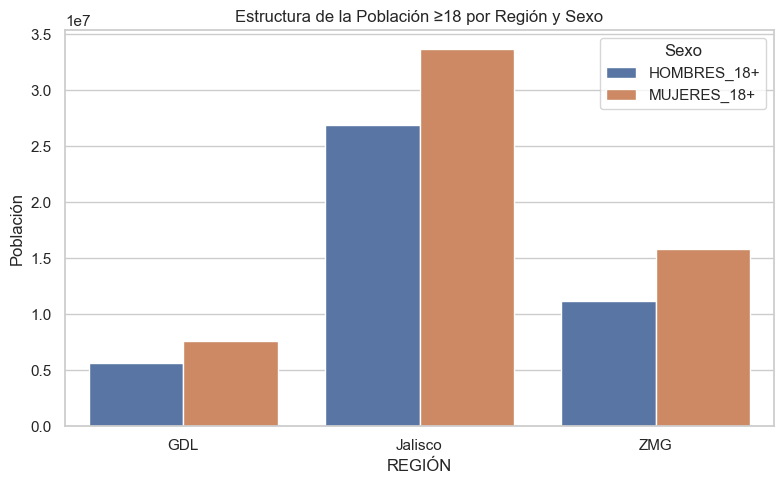

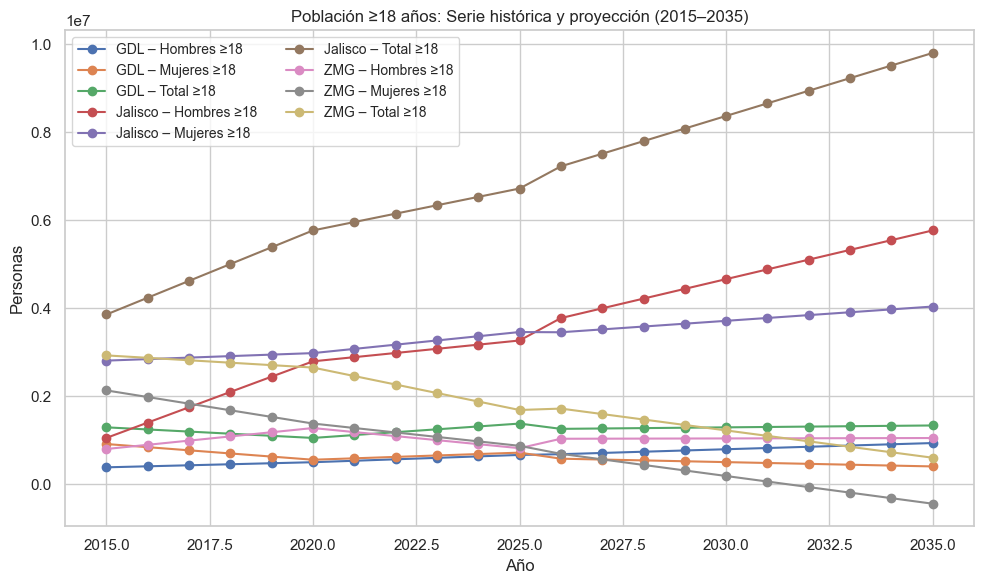

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    r2_score,
    mean_squared_error
)
from scipy import stats

# ------------------------------------
def load_and_clean(path):
    df = pd.read_csv(path)
    df = df.dropna(subset=["POB_TOT", "HOMBRES_18+", "MUJERES_18+"])
    df["REGIÓN"] = df["REGIÓN"].astype(str)  # Forzar texto
    z = np.abs(stats.zscore(df["POB_TOT"]))
    return df[z < 3].copy()

# ------------------------------------
def build_historical(master):
    frames = []
    for reg, grp in master.groupby("REGIÓN"):
        grp = grp.sort_values("AÑO").set_index("AÑO").reindex(range(2015, 2026))
        
        # Solo las columnas numéricas se interpolan
        num_cols = ["POB_TOT", "HOMBRES_18+", "MUJERES_18+"]
        grp[num_cols] = grp[num_cols].interpolate("linear").round().astype(int)

        # Añadir la región (mantener texto)
        grp["REGIÓN"] = reg
        grp = grp.reset_index()
        frames.append(grp)
    
    return pd.concat(frames, ignore_index=True)

# ------------------------------------
def logistic_majority_gender(df):
    print("\n📊 Clasificación: ¿Mayoría masculina (1) o femenina (0)?\n")
    df = df.copy()
    df["MAYORIA_HOMBRES"] = (df["HOMBRES_18+"] > df["MUJERES_18+"]).astype(int)
    
    features = ["POB_TOT", "HOMBRES_18+", "MUJERES_18+"]
    X = df[features]
    y = df["MAYORIA_HOMBRES"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))
    print(f"Precisión del modelo: {accuracy_score(y_test, y_pred):.2f}")

# ------------------------------------
def graficas_descriptivas(df):
    print("\n📈 Gráficas descriptivas...\n")
    sns.set(style="whitegrid")

    # Histograma población total
    plt.figure(figsize=(10,5))
    sns.histplot(data=df, x="POB_TOT", hue="REGIÓN", kde=True, bins=20)
    plt.title("Distribución de Población Total ≥18 por Región")
    plt.tight_layout()
    plt.show()

    # Boxplot hombres vs mujeres
    plt.figure(figsize=(8,5))
    df_melt = df.melt(id_vars=["REGIÓN"], value_vars=["HOMBRES_18+", "MUJERES_18+"],
                      var_name="Sexo", value_name="Población")
    sns.boxplot(data=df_melt, x="Sexo", y="Población", hue="REGIÓN")
    plt.title("Comparación de Población por Sexo")
    plt.tight_layout()
    plt.show()

    # Correlación
    plt.figure(figsize=(6,4))
    corr = df[["POB_TOT", "HOMBRES_18+", "MUJERES_18+"]].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm")
    plt.title("Matriz de Correlación")
    plt.tight_layout()
    plt.show()

# ------------------------------------
def estructura_poblacional(df):
    print("\n👥 Estructura de la población por región y sexo...\n")
    df_estructura = df.groupby("REGIÓN")[["HOMBRES_18+", "MUJERES_18+"]].sum().reset_index()
    df_estructura = df_estructura.melt(id_vars="REGIÓN", var_name="Sexo", value_name="Población")

    plt.figure(figsize=(8,5))
    sns.barplot(data=df_estructura, x="REGIÓN", y="Población", hue="Sexo")
    plt.title("Estructura de la Población ≥18 por Región y Sexo")
    plt.tight_layout()
    plt.show()

# ------------------------------------
def plot_series(df_all):
    plt.figure(figsize=(10,6))
    melted = df_all.melt(id_vars=["REGIÓN","AÑO"],
                         value_vars=["POB_TOT","HOMBRES_18+","MUJERES_18+"],
                         var_name="Métrica", value_name="Valor")
    for (reg, met), grp in melted.groupby(["REGIÓN","Métrica"]):
        etiqueta = met.replace("POB_TOT","Total ≥18") \
                       .replace("HOMBRES_18+","Hombres ≥18") \
                       .replace("MUJERES_18+","Mujeres ≥18")
        plt.plot(grp["AÑO"], grp["Valor"], marker="o", label=f"{reg} – {etiqueta}")
    plt.xlabel("Año")
    plt.ylabel("Personas")
    plt.title("Población ≥18 años: Serie histórica y proyección (2015–2035)")
    plt.legend(fontsize="small", ncol=2)
    plt.tight_layout()
    plt.show()

# ------------------------------------
def project_to_2035(hist_df):
    projections = []
    metrics = ["POB_TOT","HOMBRES_18+","MUJERES_18+"]
    for region, grp in hist_df.groupby("REGIÓN"):
        X = grp["AÑO"].values.reshape(-1,1)
        future = np.arange(2026,2036).reshape(-1,1)
        proj = pd.DataFrame({"AÑO": future.flatten(), "REGIÓN": region})
        for m in metrics:
            y = grp[m].values
            model = LinearRegression().fit(X, y)
            pred = model.predict(future)
            proj[m] = np.round(pred).astype(int)
            r2 = r2_score(y, model.predict(X))
            mse = mean_squared_error(y, model.predict(X))
            print(f"{region} – {m}: R²={r2:.3f}, MSE={mse:.0f}")
        projections.append(proj)
    return pd.concat(projections, ignore_index=True)

# ------------------------------------
def main():
    # 1. Cargar
    df15 = load_and_clean("../output/resumen_2015.csv")
    df20 = load_and_clean("../output/resumen_2020.csv")
    df25 = load_and_clean("../output/resumen_2025.csv")

    # 2. Consolidar
    master = pd.concat([df15, df20, df25], ignore_index=True)
    hist = build_historical(master)

    # 3. Proyección
    future = project_to_2035(hist)
    all_data = pd.concat([hist, future], ignore_index=True)

    # 4. Clasificación
    logistic_majority_gender(all_data)

    # 5. Gráficas descriptivas + estructura
    graficas_descriptivas(hist)
    estructura_poblacional(hist)

    # 6. Línea de tiempo
    plot_series(all_data)

if __name__ == "__main__":
    main()